# Connecting to MySQL Database

In [1]:
pip install pymysql

  Obtaining dependency information for pymysql from https://files.pythonhosted.org/packages/7c/4c/ad33b92b9864cbde84f259d5df035a6447f91891f5be77788e2a3892bce3/pymysql-1.1.2-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/45.3 kB ? eta -:--:--
   --------- ------------------------------ 10.2/45.3 kB ? eta -:--:--
   ------------------ --------------------- 20.5/45.3 kB 217.9 kB/s eta 0:00:01
   ------------------------------------ --- 41.0/45.3 kB 326.8 kB/s eta 0:00:01
   ---------------------------------------- 45.3/45.3 kB 321.7 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import pymysql
import os

In [2]:
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')  # Added payments.csv for specific handling
]


In [3]:
# Connect to the MySQL database
conn = pymysql.connect(
    host='127.0.0.1',
    user='root',
    password='123456',
    database='ecommerce'
)

cursor = conn.cursor()

In [4]:
# Folder containing the CSV files
folder_path = 'C:/Users/titas/Desktop/Ecommerce'

In [5]:
def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

# Data Visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymysql
conn = pymysql.connect(
    host='127.0.0.1',
    user='root',
    password='123456',
    database='ecommerce'
)
cursor = conn.cursor()

### Number of customers from each state

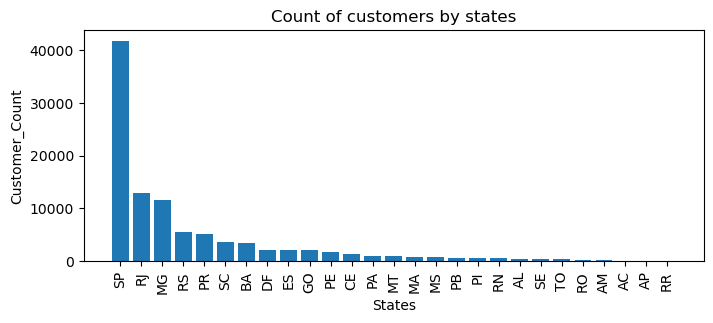

In [18]:
query = """select customer_state,count(customer_id) 
from customers 
group by customer_state
"""
cursor.execute(query)

data = cursor.fetchall()
df = pd.DataFrame(data,columns=["State","Customer_Count"])
df = df.sort_values(by = "Customer_Count", ascending = False)

plt.figure(figsize =(8,3))
plt.bar(df["State"],df["Customer_Count"])
plt.xticks(rotation = 90)
plt.xlabel("States")
plt.ylabel("Customer_Count")
plt.title("Count of customers by states")
plt.show()

### Number of orders per month in 2018

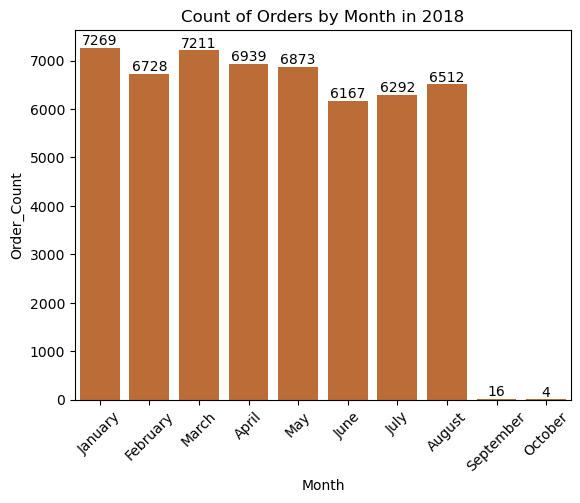

In [26]:
query = """SELECT 
monthname(order_purchase_timestamp) as "Month",
COUNT(*) as Order_Count
FROM 
orders
WHERE
YEAR(order_purchase_timestamp) = 2018
group by 1
"""
cursor.execute(query)

data = cursor.fetchall()
df = pd.DataFrame(data,columns=["Month","Order_Count"])
m = ["January","February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["Month"],y = df["Order_Count"],data = df,order = m, color = "chocolate")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Month in 2018")
plt.show()

### The correlation between product price and the number of times a product has been purchased.

In [2]:
query = """select
p.product_category,
count(oi.product_id) as order_count,
round(avg(oi.price),2) as price
from products as p
left join order_items as oi
on p.product_id = oi.product_id
group by 1
"""
cursor.execute(query)

data = cursor.fetchall()
df = pd.DataFrame(data,columns=["Category","Order_Count","Price"])
arr1 = df["Order_Count"]
arr2 = df["Price"]
np.corrcoef([arr1,arr2])


array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

<Axes: >

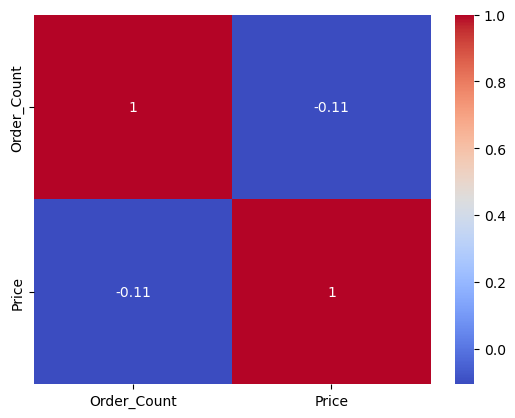

In [7]:
df1 = df[["Order_Count","Price"]]
df1_corr = df1.corr()
sns.heatmap(df1_corr,cmap='coolwarm',annot=True)